In [125]:
# Import necessary packages for Random forest classification 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
 

In [126]:
# importing imm csv file and rename columns
imm = pd.read_csv('imm_data_cur.csv')
imm['Date'] = pd.to_datetime(imm['Date'])
update_column = {'EC1':'EUR', 'EC1_Volume':'EUR_Volume','JY1':'JPY', 'JY1_Volume':'JPY_Volume', 
                'PE1':'MXN', 'PE1_Volume':'MXN_Volume', 'BP1':'GBP', 'BP1_Volume':'GBP_Volume'}

imm = imm.rename(columns= update_column)

In [127]:

def seperator(cur, db):
    '''
    Create seperate dataframe objects from single imm dataframe based on currency.
    Each new dataframe is based on a unique timeperiod. Furthermore, create new
    features that will be used for classification.
    
    inputs:
    cur: Currency to pull out of primary dataframe
    db: Dataframe to pull columns from 
    
    output:
    Five dataframes based on timeframe
    '''
    
    # Create new dataframe focusing on inputed currency
    x = db.loc[:, [cur, cur+'_Volume', cur+'_NET']]
    
    # Create new percent change variables, e_t+k - e_t
    periods = [1, 4, 8, 12, 20]
    for period in periods:
        x[cur+'_pct'+str(period)] = x[cur].pct_change(periods=period)
    
    # Create new Volume and IMM difference and scale features
    x[cur+'_Volume_pct'] = x[cur+'_Volume']-x[cur+'_Volume'].shift(-1)
    x[cur+'_IMM_pct'] = x[cur+'_NET']-x[cur+'_NET'].shift(-1)
    x[cur+'_NET_MAX']= x[cur+'_NET'].rolling(52).max()
    x[cur+'_NET_MIN']= x[cur+'_NET'].rolling(52).min()
    x['IMM_Scale'] = (x[cur+'_NET']-x[cur+'_NET_MIN'])/(x[cur+'_NET_MAX']-x[cur+'_NET_MIN'])
    
    # Remove Unneccesary columns, drop nans and reset index 
    x.drop([cur, cur+'_Volume', cur+'_NET', cur+'_NET_MAX', cur+'_NET_MAX', cur+'_NET_MIN'], axis=1, inplace=True)
    x = x.dropna()
    x = x.reset_index()
    
    # Create seperate dataframes based on exchange rate periods
    x1 = x.loc[:, [cur+'_pct1', cur+'_Volume_pct', 'IMM_Scale', cur+'_IMM_pct']]
    x2 = x.loc[:, [cur+'_pct4', cur+'_Volume_pct', 'IMM_Scale', cur+'_IMM_pct']]
    x3 = x.loc[:, [cur+'_pct8', cur+'_Volume_pct', 'IMM_Scale', cur+'_IMM_pct']]
    x4 = x.loc[:, [cur+'_pct12', cur+'_Volume_pct', 'IMM_Scale', cur+'_IMM_pct']]
    x5 = x.loc[:, [cur+'_pct20', cur+'_Volume_pct', 'IMM_Scale', cur+'_IMM_pct']]
   
    return x1, x2, x3, x4, x5
        
    
    

In [128]:
def binomial_generator(df, cur, period):
    
    '''
    Function generates binary dummy variables used for the classification problem
    
    inputs:
    df: Dataframe to create dummy variables from
    cur: Currency being analyzed
    period: Period frame being analyzed 
    
    outputs:
    df: Dataframe with weekly volume feature
    df1: Dataframe without weekly volume feature
    '''
    
    # Create future exchange rate movement dummy variable, 1 = continouation, 0 = reversal
    df['action'] = np.where(np.logical_or(
                        np.logical_and((df[cur+'_pct'+period].shift(1) < 0),(df[cur+'_pct'+period] < 0)), 
                        np.logical_and((df[cur+'_pct'+period].shift(1) > 0),(df[cur+'_pct'+period] > 0))), 1, 0)
    
    # Create IMM scale dummy variable 
    df['upper_imm'] = np.where(df['IMM_Scale']>0.95, 1, 0)
    df['lower_imm'] = np.where(df['IMM_Scale']<0.05, 1, 0)
    df.drop([cur+'_pct'+period, 'IMM_Scale'], axis=1, inplace=True)
    df1 = df.copy()
    
    # Create dataframe without weekly volume variable 
    df1.drop(cur+'_Volume_pct', axis=1, inplace=True)
    
    return df, df1

In [129]:
# First Random forest test
def ml_preper(db):
    '''
    Random forest classifier on chosen currency and generate metrics analyzing performance
    
    inputs: 
    db: Dataframe to analyze 
    
    outputs:
    scores_mean: Mean of cross-validation accuracy scores of classification
    scores_std: Standard deviation of accuracy scores
    f_score: f1 score of classification model 
    true_score: Accuracy score on test set 
    '''
    # pull x and y variable from dataframe and random sample data 
    y = db.loc[:, 'action']
    X = db.drop('action', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)
    
    # Train Random Forest Classifier and generate metrics
    rnd_clf = RandomForestClassifier()
    rnd_clf.fit(X_train, y_train)
    y_test_predict = rnd_clf.predict(X_test)
    true_score = accuracy_score(y_test, y_test_predict)
    y_pred_rf = rnd_clf.predict(X_train)
    scores_true = cross_val_score(rnd_clf, X_train, y_train, cv=10, scoring='accuracy')
    scores_mean = scores.mean()
    scores_std = scores.std()
    
    y_predict = cross_val_predict( rnd_clf, X_train, y_train, cv = 3, 
                                       method = 'predict')
    
    rf_probs = rnd_clf.predict_proba(X_test)[:, 0]
    mat_values = matthews_corrcoef(y_test, y_test_predict)
    f_score = f1_score(y_train, y_predict)
 
    
    return scores_mean, scores_std, true_score, f_score, mat_values

In [130]:
def data_aggregator(db_list):
    '''
    Organize currency metrics into lists for evaluation 
    
    input:
    db_list: list of dataframes to aggregate metrics
    
    output:
    train_accuracy: list of cross-validation random forest model accuracy
    train_std: list of standard deviation of model accuracy
    test_accuracy: list of test set accuracy
    f1_scores: list of f1 scores 
    '''
    
    # Generate empty lists to append data
    train_accuracy = []
    train_std = []
    test_accuracy = []
    f1_scores = []
    mat_scores = []
    # Loop through database list and append metrics
    for db in db_list:
        a, b, c, d, e = ml_preper(db)
        train_accuracy.append(a)
        train_std.append(b)
        test_accuracy.append(c)
        f1_scores.append(d)
        mat_scores.append(e)
    
    return train_accuracy, train_std, test_accuracy, f1_scores, mat_scores

In [131]:
imm_EUR1, imm_EUR4, imm_EUR8, imm_EUR12, imm_EUR20  = seperator('EUR', imm)
imm_JPY1, imm_JPY4, imm_JPY8, imm_JPY12, imm_JPY20  = seperator('JPY', imm)
imm_GBP1, imm_GBP4, imm_GBP8, imm_GBP12, imm_GBP20  = seperator('GBP', imm)
imm_MXN1, imm_MXN4, imm_MXN8, imm_MXN12, imm_MXN20  = seperator('MXN', imm)


In [132]:
def imbalance(db_list):
    
    imbalance_percentages = []
    
    for db in db_list:
        imb = db[db['action']==1].shape[0]/db.shape[0]
        imbalance_percentages.append(imb)
        
    return imbalance_percentages

In [133]:
# EURO Final Classification 
imm_EUR1, imm_EUR1_p = binomial_generator(imm_EUR1, 'EUR', '1')
imm_EUR4, imm_EUR4_p = binomial_generator(imm_EUR4, 'EUR', '4')
imm_EUR8, imm_EUR8_p = binomial_generator(imm_EUR8, 'EUR', '8')
imm_EUR12, imm_EUR12_p = binomial_generator(imm_EUR12, 'EUR', '12')
imm_EUR20, imm_EUR20_p = binomial_generator(imm_EUR20, 'EUR', '20')

# YEN Final Classification 
imm_JPY1, imm_JPY1_p = binomial_generator(imm_JPY1, 'JPY', '1')
imm_JPY4, imm_JPY4_p = binomial_generator(imm_JPY4, 'JPY', '4')
imm_JPY8, imm_JPY8_p = binomial_generator(imm_JPY8, 'JPY', '8')
imm_JPY12, imm_JPY12_p = binomial_generator(imm_JPY12, 'JPY', '12')
imm_JPY20, imm_JPY20_p = binomial_generator(imm_JPY20, 'JPY', '20')

# POUND Final Classification 
imm_GBP1, imm_GBP1_p = binomial_generator(imm_GBP1, 'GBP', '1')
imm_GBP4, imm_GBP4_p = binomial_generator(imm_GBP4, 'GBP', '4')
imm_GBP8, imm_GBP8_p = binomial_generator(imm_GBP8, 'GBP', '8')
imm_GBP12, imm_GBP12_p= binomial_generator(imm_GBP12, 'GBP', '12')
imm_GBP20, imm_GBP20_p = binomial_generator(imm_GBP20, 'GBP', '20')

# PESO Final Classification 
imm_MXN1, imm_MXN1_p = binomial_generator(imm_MXN1, 'MXN', '1')
imm_MXN4, imm_MXN4_p= binomial_generator(imm_MXN4, 'MXN', '4')
imm_MXN8, imm_MXN8_p = binomial_generator(imm_MXN8, 'MXN', '8')
imm_MXN12, imm_MXN12_p = binomial_generator(imm_MXN12, 'MXN', '12')
imm_MXN20, imm_MXN20_p = binomial_generator(imm_MXN20, 'MXN', '20')

In [137]:
JPY_imbalances = imbalance([imm_JPY1, imm_JPY4, imm_JPY8, imm_JPY12, imm_JPY20])
JPYp_imbalances = imbalance([imm_JPY1_p, imm_JPY4_p, imm_JPY8_p, imm_JPY12_p, imm_JPY20_p])
MXN_imbalances = imbalance([imm_MXN1, imm_MXN4, imm_MXN8, imm_MXN12, imm_MXN20])
MXNp_imbalances = imbalance([imm_MXN1_p, imm_MXN4_p, imm_MXN8_p, imm_MXN12_p, imm_MXN20_p])
EUR_imbalances = imbalance([imm_EUR1, imm_EUR4, imm_EUR8, imm_EUR12, imm_EUR20])
EURp_imbalances = imbalance([imm_EUR1_p, imm_EUR4_p, imm_EUR8_p, imm_EUR12_p, imm_EUR20_p])
GBP_imbalances = imbalance([imm_GBP1, imm_GBP4, imm_GBP8, imm_GBP12, imm_GBP20])
GBPp_imbalances = imbalance([imm_GBP1_p, imm_GBP4_p, imm_GBP8_p, imm_GBP12_p, imm_GBP20_p])

In [65]:

# Peso Metrics
MXN_train_accuracy, MXN_train_std, MXN_test_accuracy, MXN_f1_scores, MXN_mat_Scores = data_aggregator([imm_MXN1,imm_MXN4, imm_MXN8, imm_MXN12, imm_MXN20])
MXNp_train_accuracy, MXNp_train_std, MXNp_test_accuracy, MXNp_f1_scores, MXNp_mat_Scores = data_aggregator([imm_MXN1_p,imm_MXN4_p, imm_MXN8_p, imm_MXN12_p, imm_MXN20_p])

# Euro Metrics
EUR_train_accuracy, EUR_train_std, EUR_test_accuracy, EUR_f1_scores, EUR_mat_Scores = data_aggregator([imm_EUR1,imm_EUR4, imm_EUR8, imm_EUR12, imm_EUR20])
EURp_train_accuracy, EURp_train_std, EURp_test_accuracy, EURp_f1_scores, EURp_mat_Scores = data_aggregator([imm_EUR1_p,imm_EUR4_p, imm_EUR8_p, imm_EUR12_p, imm_EUR20_p])

# Yen Metrics
JPY_train_accuracy, JPY_train_std, JPY_test_accuracy, JPY_f1_scores, JPY_mat_Scores = data_aggregator([imm_JPY1,imm_JPY4, imm_JPY8, imm_JPY12, imm_JPY20])
JPYp_train_accuracy, JPYp_train_std, JPYp_test_accuracy, JPYp_f1_scores, JPYp_mat_Scores = data_aggregator([imm_JPY1_p,imm_JPY4_p, imm_JPY8_p, imm_JPY12_p, imm_JPY20_p])

# Pound Metrics
GBP_train_accuracy, GBP_train_std, GBP_test_accuracy, GBP_f1_scores, GBP_mat_Scores = data_aggregator([imm_GBP1,imm_GBP4, imm_GBP8, imm_GBP12, imm_GBP20])
GBPp_train_accuracy, GBPp_train_std, GBPp_test_accuracy, GBPp_f1_scores, GBPp_mat_Scores = data_aggregator([imm_GBP1_p,imm_GBP4_p, imm_GBP8_p, imm_GBP12_p, imm_GBP20_p])


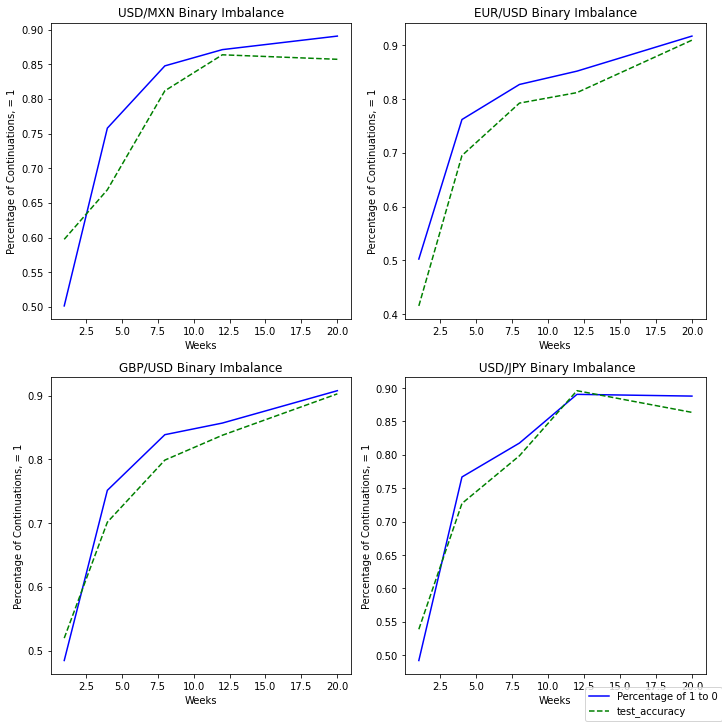

In [140]:

periods = [1, 4, 8, 12, 20]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plotting Cross-validation accuracy mean
axs[0, 0].set_title("USD/MXN Binary Imbalance")
axs[0, 0].plot(periods, MXN_imbalances, color='b')
axs[0, 0].plot(periods, MXN_test_accuracy, color='g', linestyle='--')
axs[0, 0].set_ylabel("Percentage of Continuations, = 1")
axs[0, 0].set_xlabel("Weeks")

# Plotting accuracy std
axs[0, 1].set_title("EUR/USD Binary Imbalance")
axs[0, 1].plot(periods, EUR_imbalances, color='b')
axs[0, 1].plot(periods, EUR_test_accuracy, color='g', linestyle='--')
axs[0, 1].set_ylabel("Percentage of Continuations, = 1")
axs[0, 1].set_xlabel("Weeks")

# Plotting test accuracy 
axs[1, 0].set_title("GBP/USD Binary Imbalance")
axs[1, 0].plot(periods, GBP_imbalances, color='b')
axs[1, 0].plot(periods, GBP_test_accuracy, color='g', linestyle='--')
axs[1, 0].set_ylabel("Percentage of Continuations, = 1")
axs[1, 0].set_xlabel("Weeks")

# Plotting f1 score
axs[1, 1].set_title(" USD/JPY Binary Imbalance")
axs[1, 1].plot(periods, JPY_imbalances, color='b')
axs[1, 1].plot(periods, JPY_test_accuracy, color='g', linestyle='--')
axs[1, 1].set_ylabel("Percentage of Continuations, = 1")
axs[1, 1].set_xlabel("Weeks")


fig.legend(     # The line objects
           labels=['Percentage of 1 to 0', 'test_accuracy'],    # The labels for each line
           loc="lower right",   # Position of legend
           borderaxespad=0.1)    # Small spacing around legend box
fig.tight_layout()
           
fig.savefig("Imbalances.png")
plt.show()

In [48]:
print(JPY_roc_Scores)
print(JPYp_roc_Scores)

[0.4294028340080972, 0.5375470809792844, 0.5619331065759637, 0.3885787891799055, 0.45234006011163597]
[0.36639676113360314, 0.4864642184557439, 0.552295918367347, 0.4652211249463289, 0.4199227136109918]
